# Apply PCM to argo reference data base

First try

In [3]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter

import subprocess

from BIC_calculation import *

import argopy
from argopy.xarray import *

import scipy as sp
from scipy.io import loadmat
from scipy import interpolate

In [4]:
def interpolate_standard_levels(ds, std_lev):
    """ Interpolate data to given presure standard levels (from interp_std_levels in argopy)
    
        Parameters
        ----------
        ds: dataset to be interpolated
        std_lev: array of pres standard values
        
        Returns
        -------
        Datset array with interpolated values
    """
    
    # Selecting profiles that have a max(pressure) > max(std_lev) to avoid extrapolation in that direction
    # For levels < min(pressure), first level values of the profile are extended to surface.
    i1 = (ds['pres'].max('n_pres') >= std_lev[-1])
    ds = ds.where(i1, drop=True)
    
    # check if any profile is left, ie if any profile match the requested depth
    if (len(ds['n_profiles']) == 0):
        raise Warning(
                'None of the profiles can be interpolated (not reaching the requested depth range).')
        return None

    # add new vertical dimensions, this has to be in the datasets to apply ufunc later
    ds['z_levels'] = xr.DataArray(std_lev, dims={'z_levels': std_lev})
    
    # init
    ds_out = xr.Dataset()
    
    # vars to interpolate
    datavars = [dv for dv in list(ds.variables) if set(['n_pres', 'n_profiles']) == set(
            ds[dv].dims) and 'ptmp' not in dv]
    # coords
    coords = [dv for dv in list(ds.coords)]
    # vars depending on N_PROF only
    solovars = [dv for dv in list(
            ds.variables) if dv not in datavars and dv not in coords and 'QC' not in dv and 'ERROR' not in dv]
    for dv in datavars:
        ds_out[dv] = linear_interpolation_remap(
                ds.pres, ds[dv], ds['z_levels'], z_dim='n_pres', z_regridded_dim='z_levels')
    ds_out = ds_out.rename({'remapped': 'PRES_INTERPOLATED'})
    for sv in solovars:
        ds_out[sv] = ds[sv]

    for co in coords:
        ds_out.coords[co] = ds[co]

    #ds_out = ds_out.drop_vars(['n_pres', 'z_levels'])
    ds_out = ds_out[np.sort(ds_out.data_vars)]
    ds_out.attrs = ds.attrs  # Preserve original attributes
    #ds_out.argo._add_history('Interpolated on standard levels')

    return ds_out

In [5]:
def linear_interpolation_remap(
    z, data, z_regridded, z_dim=None, z_regridded_dim="regridded", output_dim="remapped"
):

    # interpolation called in xarray ufunc
    def _regular_interp(x, y, target_values):
        # remove all nans from input x and y
        idx = np.logical_or(np.isnan(x), np.isnan(y))
        x = x[~idx]
        y = y[~idx]

        # Need at least 5 points in the profile to interpolate, otherwise, return NaNs
        if len(y) < 5:
            interpolated = np.empty(len(target_values))
            interpolated[:] = np.nan
        else:
            # replace nans in target_values with out of bound Values (just in case)
            target_values = np.where(
                ~np.isnan(target_values), target_values, np.nanmax(x) + 1
            )
            # Interpolate with fill value parameter to extend min pressure toward 0
            interpolated = interpolate.interp1d(
                x, y, bounds_error=False, fill_value=(y[0], y[-1])
            )(target_values)
        return interpolated

    # infer dim from input
    if z_dim is None:
        if len(z.dims) != 1:
            raise RuntimeError("if z_dim is not specified,x must be a 1D array.")
        dim = z.dims[0]
    else:
        dim = z_dim

    # if dataset is passed drop all data_vars that dont contain dim
    if isinstance(data, xr.Dataset):
        raise ValueError("Dataset input is not supported yet")
        # TODO: for a dataset input just apply the function for each appropriate array

    kwargs = dict(
        input_core_dims=[[dim], [dim], [z_regridded_dim]],
        output_core_dims=[[output_dim]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[data.dtype],
        output_sizes={output_dim: len(z_regridded[z_regridded_dim])},
    )
    remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)

    remapped.coords[output_dim] = z_regridded.rename(
        {z_regridded_dim: output_dim}
    ).coords[output_dim]
    return remapped

In [ ]:
def find_25boxes(pn_float_long, pn_float_lat, pa_wmo_boxes):
    """ Find WMO boxes centered on profile
        Finds the 5 x 5 = 25 WMO boxes with the float profile in the centre
        The WMO box numbers, between 90N and 90S are stored in /data/constants/wmo_boxes.mat
        The structure of the matrix is as such:
        Column 1 - box number
        Column 2 - Do we have CTD data (1 = yes, 0 = no)
        Column 3 - Do we have bottle data (1 = yes, 0 = no)
        Column 4 - do we have Argo data (1 = yes, 0 = no)
        N.B. Change to code on the xx/11/2014: extend la_x so interp2 does not
        think that longitudes in the range [5W 5E] are out-of-bound with matlab
        version >=R2012b - C Cabanes
        N.B. Change during conversion to python on the 01/10/2019. Struggled to
        find an interpolation function that exactly mirrored Matlab's, so
        I wrote my own - Edward Small
        First, we need to create a look-up table in the form of
        .. code-block::
               | -5    5   15  ...  355  365
           ----|----------------------------
            85 | 631   1   19  ...  631   1
            75 | 632   2   20  ...  632   2
            65 | 633   3   21  ...  633   3
            ...|...   ...  ... ...  ...  ...
            -85| 648   18  36  ...  648   18
        ..
         We do this using 3 matrices:
         - A 1-D matrix for the x axis (la_lookup_x)
         - A 1-D matrix for the y axis (la_lookup_y)
         - A 2-D matrix for the grid data (la_lookup_no)
        Parameters
        ----------
        pn_float_long: float longitude, float
        pn_float_lat: float latitude, float
        pa_wmo_boxes: wmo boxes (explained above), data frame
        Returns
        -------
        (explained above), 25x4 matrix
    """

    la_lookup_x = np.arange(-5, 366, 10, int)

    la_lookup_y = np.arange(85, -86, -10).transpose()

    la_lookup_no = np.full((1, 648), np.arange(1, 649), dtype=int).reshape(36, 18)
    la_lookup_no = np.insert(
        la_lookup_no, 0, la_lookup_no[la_lookup_no.shape[0] - 1]
    ).reshape(37, 18)
    la_lookup_no = np.insert(la_lookup_no, 666, la_lookup_no[1]).reshape(38, 18).transpose()

    # Set up longitudinal and latitudinal values
    ln_x = []
    ln_y = []
    ln_x.append(pn_float_long + .01)
    ln_x.append(pn_float_long + 10.01)
    ln_x.append(pn_float_long - 9.99)
    ln_x.append(pn_float_long + 20.01)
    ln_x.append(pn_float_long - 19.99)

    ln_y.append(pn_float_lat + .01)
    ln_y.append(pn_float_lat + 10.01)
    ln_y.append(pn_float_lat - 9.99)
    ln_y.append(pn_float_lat + 20.01)
    ln_y.append(pn_float_lat - 19.99)

    # wrap longitudinal values
    if ln_x[2] < 0:
        ln_x[2] += 360

    if ln_x[4] < 0:
        ln_x[4] += 360

    if ln_x[0] >= 360:
        ln_x[0] -= 360

    if ln_x[1] >= 360:
        ln_x[1] -= 360

    if ln_x[3] >= 360:
        ln_x[3] -= 360

    if not np.isnan(pn_float_long) and not np.isnan(pn_float_lat):
        ln_i = []
        for i in range(0, 5):
            for j in range(0, 5):
                ln_i.append(
                    nearest_neighbour(la_lookup_x, la_lookup_y, la_lookup_no, ln_x[j], ln_y[i])
                )

    else:
        ln_i = np.full(25, np.nan)

    pa_wmo_numbers = np.full((25, 4), np.nan)
    for i in range(0, 25):
        if not np.isnan(ln_i[i]):
            pa_wmo_numbers[i] = pa_wmo_boxes.get('la_wmo_boxes')[ln_i[i] - 1]

    return pa_wmo_numbers

## 1. Load argo reference database

Data selection

In [6]:
# geographical extent
geo_extent = [-5, 42, 30, 46] # [min lon, max lon, min lat, max lat]

load from .mat as dict

In [7]:
ref_path = '/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology/argo_profiles/'
mat_dict = sp.io.loadmat(ref_path + 'argo_3200.mat')
#mat_dict

convert from dict to xarray

In [8]:
ds = xr.Dataset(
     data_vars=dict(
         pres=(["n_pres", "n_profiles"], mat_dict['pres']),
         temp=(["n_pres", "n_profiles"], mat_dict['temp']),
         ptmp=(["n_pres", "n_profiles"], mat_dict['ptmp']),
         sal=(["n_pres", "n_profiles"], mat_dict['sal']),
         source=(["n_profiles"], np.squeeze(mat_dict['source'])),
     ),
     coords=dict(
         long=(["n_profiles"], np.squeeze(mat_dict['long'])),
         lat=(["n_profiles"], np.squeeze(mat_dict['lat'])),
         dates=(["n_profiles"], np.squeeze(mat_dict['dates'])),
     ),
     attrs=dict(
         __header__=mat_dict['__header__'],
         __version__=mat_dict['__version__'],
         __globals__=mat_dict['__version__'],
     )
 )

In [8]:
ds

<xarray.Dataset>
Dimensions:  (n_pres: 1024, n_profiles: 2252)
Coordinates:
    long     (n_profiles) float64 9.577 9.848 9.281 9.616 ... 8.818 9.358 9.931
    lat      (n_profiles) float64 -26.74 -25.99 -26.84 ... -25.21 -25.29 -24.9
    dates    (n_profiles) float64 2.005e+13 2.005e+13 ... 2.018e+13 2.018e+13
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 10.0 10.0 10.0 10.0 ... nan nan nan
    temp     (n_pres, n_profiles) float64 22.23 21.85 17.04 ... nan nan nan
    ptmp     (n_pres, n_profiles) float64 22.23 21.85 17.04 ... nan nan nan
    sal      (n_pres, n_profiles) float64 35.49 35.39 35.56 ... nan nan nan
    source   (n_profiles) object ['1900165_078.BRECKOWENS'] ... ['6902631_093.BirgitKLEIN']
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue N...
    __version__:  1.0
    __globals__:  1.0

interpolate to standard levels

In [9]:
std_lev = np.arange(0,500)
ds_out = interpolate_standard_levels(ds, std_lev)
ds_out

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 500, n_pres: 1024, n_profiles: 2241)
Coordinates:
    dates              (n_profiles) float64 2.005e+13 2.005e+13 ... 2.018e+13
    lat                (n_profiles) float64 -26.74 -25.99 ... -25.29 -24.9
    long               (n_profiles) float64 9.577 9.848 9.281 ... 9.358 9.931
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 1 2 3 4 ... 496 497 498 499
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 10.0 ... 499.0
    ptmp               (n_pres, n_profiles) float64 22.23 21.85 ... nan nan
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.49 ... 34.51
    source             (n_profiles) object ['1900165_078.BRECKOWENS'] ... ['6902631_093.BirgitKLEIN']
    temp               (n_profiles, PRES_INTERPOLATED) float64 22.23 ... 7.307
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue N...
    __version__:  1.0
    __globals__:  1.0

some format

In [10]:
#pres should be negative for the PCM
ds_out['PRES_INTERPOLATED'] = -np.abs(ds_out['PRES_INTERPOLATED'].values)
#axis attributtes for plotter class
ds_out.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds_out.lat.attrs['axis'] = 'Y'
ds_out.long.attrs['axis'] = 'X'
ds_out.long.attrs['axis'] = 'T'

In [11]:
ds_out

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 500, n_pres: 1024, n_profiles: 2241)
Coordinates:
    long               (n_profiles) float64 9.577 9.848 9.281 ... 9.358 9.931
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -497 -498 -499
    dates              (n_profiles) float64 2.005e+13 2.005e+13 ... 2.018e+13
    lat                (n_profiles) float64 -26.74 -25.99 ... -25.29 -24.9
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 10.0 ... 499.0
    ptmp               (n_pres, n_profiles) float64 22.23 21.85 ... nan nan
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.49 ... 34.51
    source             (n_profiles) object ['1900165_078.BRECKOWENS'] ... ['6902631_093.BirgitKLEIN']
    temp               (n_profiles, PRES_INTERPOLATED) float64 22.23 ... 7.307
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue N...
    __version__:  1.0
    __globals__:  1.0

some plots

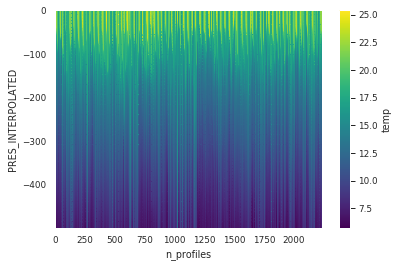

In [27]:
ds_out['temp'].plot(x='n_profiles');

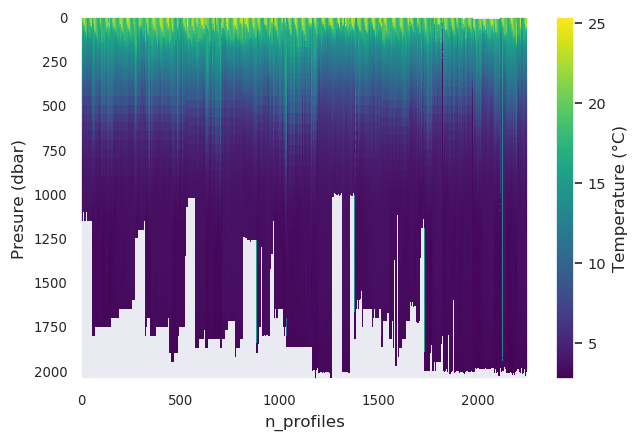

In [37]:
import numpy.ma as ma
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
sc = ax.pcolor(np.tile(ds['n_profiles'], (1024,1)), ds['pres'], ds['temp'], cmap='viridis')
ax.invert_yaxis()
cbar = plt.colorbar(sc)
cbar.set_label('Temperature (°C)', fontsize=10)
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)
ax.set_ylabel('Presure (dbar)', fontsize=10);
ax.set_xlabel('n_profiles', fontsize=10);

In [ ]:
import numpy.ma as ma
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), dpi=120, facecolor='w', edgecolor='k')
ax.plot(ds['pres'], ds['temp'])

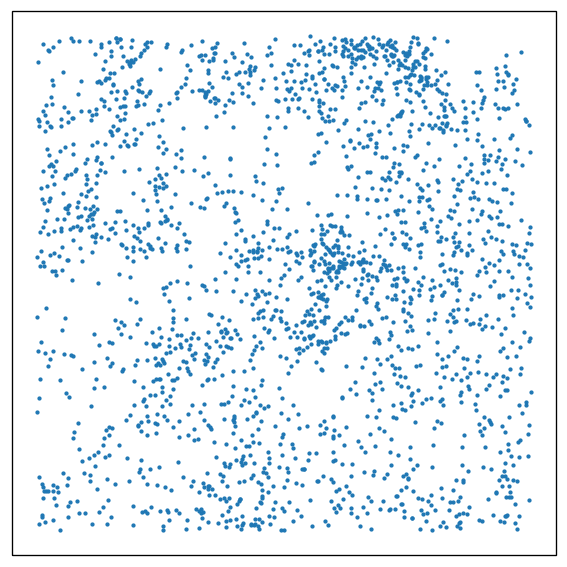

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            6, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

sc = ax.scatter(ds['long'], ds['lat'], s=3, transform=proj)

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

In [ ]:
# geographical extent
geo_extent = [-5, 42, 30, 46] # [min lon, max lon, min lat, max lat]
# time extent
time_extent = ["2018-01-01", "2018-12-31"] # ["min date", "max date"]
# variable to be predict
var_name_ds = 'thetao' # name in dataset
# file name
file_name = 'global-reanalysis-phy-001-030-monthly_med_2018.nc'

## 2. Apply PCM

Create model

In [15]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = 'sal'
K=2

# pcm feature
z = ds_out[z_dim]
pcm_features = {var_name_mdl: z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 2, F: 1)>
Number of class: 2
Number of feature: 1
Feature names: odict_keys(['sal'])
Fitted: False
Feature: 'sal'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

Fit model

In [16]:
var_name_ds = 'sal'
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl : var_name_ds}

m.fit_predict(ds_out, features=features_in_ds, dim=z_dim, inplace=True)
m

<pcm 'gmm' (K: 2, F: 1)>
Number of class: 2
Number of feature: 1
Feature names: odict_keys(['sal'])
Fitted: True
Feature: 'sal'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: -28.234377

In [21]:
m.predict_proba(ds_out, features=features_in_ds, dim=z_dim, inplace=True);

In [22]:
ds_out = ds_out.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds, outname=var_name_ds + '_Q', keep_attrs=True, inplace=True)

In [23]:
ds_out

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 500, n_pres: 1024, n_profiles: 2241, pcm_class: 2, quantile: 3)
Coordinates:
  * pcm_class          (pcm_class) int64 0 1
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 2236 2237 2238 2239 2240
    long               (n_profiles) float64 9.577 9.848 9.281 ... 9.358 9.931
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -497 -498 -499
    dates              (n_profiles) float64 2.005e+13 2.005e+13 ... 2.018e+13
    lat                (n_profiles) float64 -26.74 -25.99 ... -25.29 -24.9
  * quantile           (quantile) float64 0.05 0.5 0.95
Dimensions without coordinates: n_pres
Data variables:
    pres               (n_profiles, PRES_INTERPOLATED) float64 10.0 ... 499.0
    ptmp               (n_pres, n_profiles) float64 22.23 21.85 ... nan nan
    sal                (n_profiles, PRES_INTERPOLATED) float64 35.49 ... 34.51
    source             (n_profiles) object ['1900165_078.BRECKOWENS'] ... ['6902631_093.BirgitKLEIN']
    temp               (n_profiles, PRES_INTERPOLATED) float64 22.23 ... 7.307
    PCM_LABELS         (n_profiles) int64 0 0 1 1 1 0 0 0 0 ... 0 0 0 0 0 0 0 0
    PCM_POST           (pcm_class, n_profiles) float64 1.0 1.0 ... 3.93e-33
    sal_Q              (pcm_class, quantile, PRES_INTERPOLATED) float64 35.41 ... 34.73
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue N...
    __version__:  1.0
    __globals__:  1.0

## 3. Plots

In [24]:
P = Plotter(ds_out, m, coords_dict= {'latitude': 'lat', 'longitude': 'long'})
P.data_type = 'profiles'

vertical structure

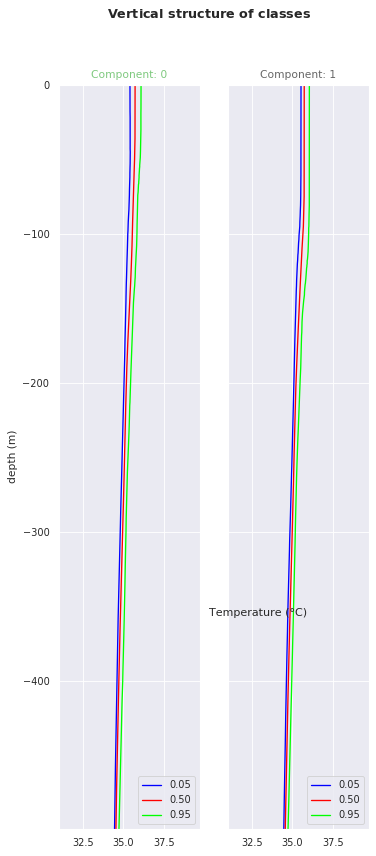

In [25]:
P.vertical_structure(q_variable = var_name_ds + '_Q', sharey=True, xlabel='Temperature (°C)')

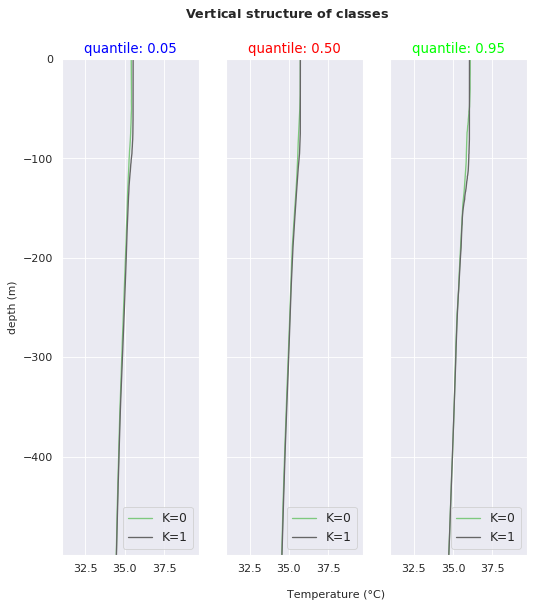

In [27]:
P.vertical_structure_comp(q_variable = var_name_ds + '_Q', plot_q= 'all', xlabel='Temperature (°C)')

spatial distribution

[  0.        9.999   -29.997   -20.00318]


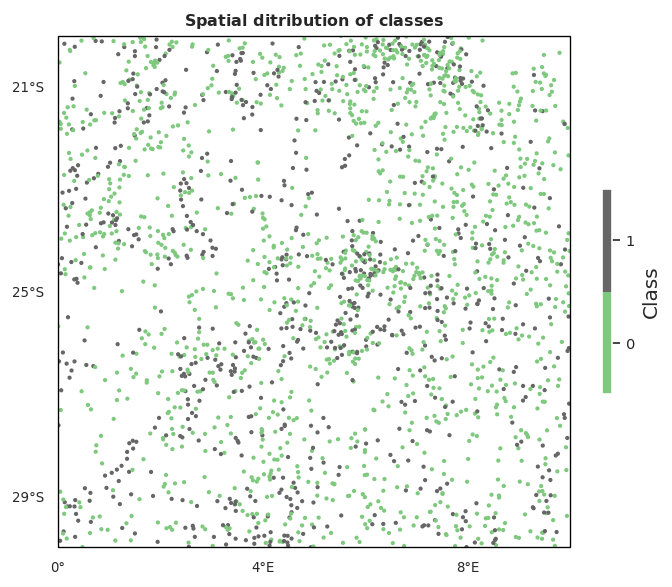

In [19]:
P.spatial_distribution()